#**Step 1: Setup Environment**

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth unsloth_zoo  # Add unsloth_zoo explicitly
else:
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

In [ ]:
!pip install rouge-score

In [ ]:
  # In Colab, run this cell before anything else
%env PYTHON_VERSION=3.10

env: PYTHON_VERSION=3.10


#**Step 2: Load Dataset**

In [ ]:
import pandas as pd
from datasets import Dataset

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/WR/Project/Summarization.csv")  # Replace with your file path
df = df.drop(columns=['Unnamed: 0'])  # Drop Unnamed: 0
print(df.head())

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
print(f"Dataset size: {len(dataset)}")

# Optional: Split into train/val
train_test_split = dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
val_dataset = train_test_split['test']

                                                text  \
0  លោក Pep Guardiola គ្រូបង្វឹក Man City បាននិយាយ...   
1  លោក Luis Enrique គ្រូបង្វឹក Paris Saint Germai...   
2  អង់គ្លេស៖ ក្រុមមាន់ខ្នាយមាស Tottenham Hotspur ...   
3  សហព័ន្ធបាល់ទាត់អឺរ៉ុប UEFA នឹងធ្វើសេចក្ដីសម្រេ...   
4  ថ្មីៗនេះ មានរបាយការណ៍មកថា តារាឆ្នើមក្រុម Arsen...   

                                             summary  
0  Man City ឈ្នះជើងឯក Premier League រដូវកាល ២០២២...  
1  លោក Luis Enrique បដិសេធពាក្យចចាមអារ៉ាមថា ចង់ចា...  
2  Tottenham Hotspur នឹងប្រឹងប្រយុទ្ធប្រកួតជាមួយ ...  
3  UEFA នឹងសម្រេចក្នុងខែមិថុនាថា Barcelona ត្រូវដ...  
4  Bukayo Saka កីឡាកររបស់ Arsenal កំពុងទាក់ទាញចំណ...  
Dataset size: 3021


#**Step 3: Load Model & Tokenizer (Qwen3 with Unsloth)**

In [ ]:
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-4B-Instruct-2507",
    max_seq_length = 2048,
    load_in_4bit = True,
    load_in_8bit = False,
    full_finetuning = False,
)

model = FastLanguageModel.get_peft_model(
    model,
    r = 32,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 32,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(tokenizer, chat_template="qwen3-instruct")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2026.1.2 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


#**Step 4: Format Data for Training**

In [ ]:
def formatting_prompts_func(examples):
    texts = []
    for text, summary in zip(examples["text"], examples["summary"]):
        prompt = f"""<|im_start|>user\n{text}<|im_end|>\n<|im_start|>assistant\n{summary}<|im_end|>"""
        texts.append(prompt)
    return {"text": texts}

# Apply formatting
train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
val_dataset = val_dataset.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/2718 [00:00<?, ? examples/s]

Map:   0%|          | 0/303 [00:00<?, ? examples/s]

#**Step 5: Train with SFTTrainer (Unsloth)**

In [ ]:
from trl import SFTTrainer, SFTConfig

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # For validation loss
    args=SFTConfig(
        dataset_text_field="text",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=300,  # ~2-3 hours on 15GB VRAM
        learning_rate=2e-4,
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.001,
        lr_scheduler_type="linear",
        seed=3407,
        report_to="none",
        output_dir="output_dir",  # Save checkpoints
    ),
)

# Enable training on responses only (more efficient)
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part="user\n",
    response_part="assistant\n",
)

Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/2718 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/303 [00:00<?, ? examples/s]

🦥 Unsloth: Padding-free auto-enabled, enabling faster training.


Map (num_proc=6):   0%|          | 0/2718 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/303 [00:00<?, ? examples/s]

#**Step 6: Monitor Training & Plot Losses**

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,718 | Num Epochs = 1 | Total steps = 300
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 66,060,288 of 4,088,528,384 (1.62% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,0.728300
2,0.521800
3,0.651300
4,0.542100
5,0.588700
6,0.528600
7,0.423900
8,0.460500
9,0.418700
10,0.407200


Step,Training Loss
1,0.728300
2,0.521800
3,0.651300
4,0.542100
5,0.588700
6,0.528600
7,0.423900
8,0.460500
9,0.418700
10,0.407200


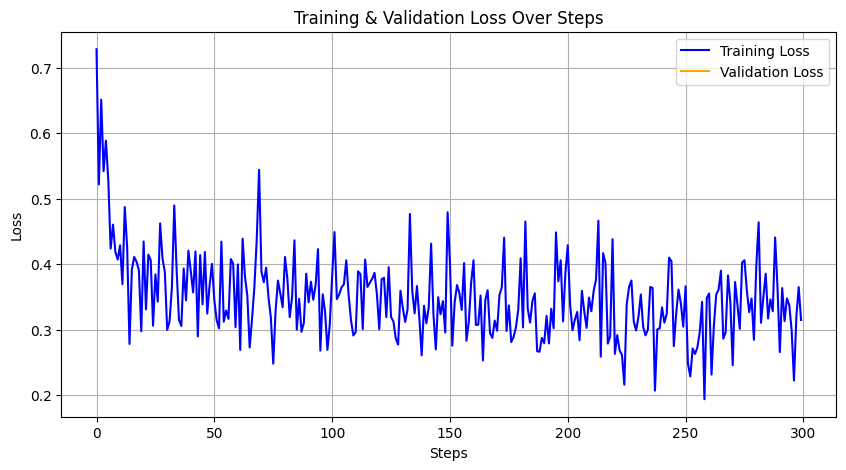

In [ ]:
# Train and collect logs
trainer_stats = trainer.train()

# Extract training and validation losses
import matplotlib.pyplot as plt
import numpy as np

# Get logs from trainer
logs = trainer.state.log_history

# Extract losses
train_losses = [log.get("loss", float('inf')) for log in logs if "loss" in log]
val_losses = [log.get("eval_loss", float('inf')) for log in logs if "eval_loss" in log]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", color='blue')
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Steps")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save LoRA adapters
model.save_pretrained("Qwen_lora_model")
tokenizer.save_pretrained("Qwen_lora_model")

# Optionally merge to 16-bit or GGUF
if False:
    model.save_pretrained_merged("merged_model", tokenizer, save_method="merged_16bit")

#**Step 7: Evaluate with ROUGE Scores**

In [ ]:
!pip install -U accelerate peft transformers
!pip install -U bitsandbytes
!pip install rouge-score datasets transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 109.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.2
    Uninstalling transformers-4.56.2:
      Successfully uninstalled transformers-4.56.2
  Attempting uninstall: peft
    Found existing installation: peft 0.18.0
    Uninstalling peft-0.18.0:
      Successfully uninstalled peft-0.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth 2026.1.2 requires tyro, which is not installed.
unsloth-zoo 2026.1.2 requires msgspec, which is not installed.
unsloth-zoo 2026.1.2 requires tyro, which is not installed.
unsloth-zoo 2026.1.2 requires torchao>=0.13.0, but you have torchao 0.10.0 whic

In [ ]:
# Install required packages (run once)
# !pip install rouge-score datasets transformers accelerate

# Imports
from rouge_score import rouge_scorer
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# ----------------------------
# 1. Load and prepare dataset
# ----------------------------
df = pd.read_csv("/content/drive/MyDrive/WR/Project/Summarization.csv")
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
print("Columns:", df.columns.tolist())
print(df.head())

assert 'text' in df.columns and 'summary' in df.columns, "CSV must contain 'text' and 'summary'"

dataset = Dataset.from_pandas(df)
print(f"Dataset size: {len(dataset)}")

train_test_split = dataset.train_test_split(test_size=0.1)
val_dataset = train_test_split['test']

# ----------------------------
# 2. Load Qwen Model & Tokenizer
# ----------------------------
model_name = "/content/drive/MyDrive/WR/Qwen_lora_model"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,  # or torch.float16
    device_map="auto",
    trust_remote_code=True
)
model.eval()

# ----------------------------
# 3. ROUGE Scorer (unchanged)
# ----------------------------
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

def compute_rouge_scores_batch(predictions, references):
    scores = []
    for pred, ref in zip(predictions, references):
        pred = pred.strip() if pred.strip() else " "
        ref = ref.strip() if ref.strip() else " "
        score = scorer.score(ref, pred)
        scores.append(score)
    return {
        'rouge1': np.mean([s['rouge1'].fmeasure for s in scores]),
        'rouge2': np.mean([s['rouge2'].fmeasure for s in scores]),
        'rougeL': np.mean([s['rougeL'].fmeasure for s in scores]),
    }

# ----------------------------
# 4. Generate Summaries with Prompting
# ----------------------------
def build_prompt(text):
    # Use Qwen's expected chat format if it was trained that way
    # If unsure, use a simple instruction prompt
    return f"Summarize the following text in one paragraph:\n\n{text}\n\nSummary:"

batch_size = 4  # Reduce batch size for large models
eval_subset = val_dataset.select(range(min(50, len(val_dataset))))

all_preds = []
all_refs = []

for i in range(0, len(eval_subset), batch_size):
    batch = eval_subset[i:i + batch_size]

    # Build prompts
    prompts = [build_prompt(text) for text in batch["text"]]

    # Tokenize
    inputs = tokenizer(
        prompts,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=2048,  # Qwen supports long context
        add_special_tokens=True
    ).to(model.device)

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.7,
            top_p=0.9,
            top_k=20,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id if tokenizer.pad_token_id else tokenizer.eos_token_id
        )

    # Decode full output
    decoded_full = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Extract only the generated part (after the prompt)
    predictions = []
    for prompt, full_text in zip(prompts, decoded_full):
        # Remove the prompt part
        if full_text.startswith(prompt):
            gen = full_text[len(prompt):].strip()
        else:
            # Fallback: take everything (may include prompt repetition)
            gen = full_text.strip()
        predictions.append(gen)

    all_preds.extend(predictions)
    all_refs.extend(batch["summary"])

# ----------------------------
# 5. Compute ROUGE
# ----------------------------
rouge_results = compute_rouge_scores_batch(all_preds, all_refs)
print("\nROUGE Scores:")
for k, v in rouge_results.items():
    print(f"{k}: {v:.4f}")

# Optional: Inspect a few examples
print("\nSample Predictions:")
for i in range(3):
    print(f"Ref: {all_refs[i][:200]}...")
    print(f"Pred: {all_preds[i][:200]}...\n")

Columns: ['text', 'summary']
                                                text  \
0  លោក Pep Guardiola គ្រូបង្វឹក Man City បាននិយាយ...   
1  លោក Luis Enrique គ្រូបង្វឹក Paris Saint Germai...   
2  អង់គ្លេស៖ ក្រុមមាន់ខ្នាយមាស Tottenham Hotspur ...   
3  សហព័ន្ធបាល់ទាត់អឺរ៉ុប UEFA នឹងធ្វើសេចក្ដីសម្រេ...   
4  ថ្មីៗនេះ មានរបាយការណ៍មកថា តារាឆ្នើមក្រុម Arsen...   

                                             summary  
0  Man City ឈ្នះជើងឯក Premier League រដូវកាល ២០២២...  
1  លោក Luis Enrique បដិសេធពាក្យចចាមអារ៉ាមថា ចង់ចា...  
2  Tottenham Hotspur នឹងប្រឹងប្រយុទ្ធប្រកួតជាមួយ ...  
3  UEFA នឹងសម្រេចក្នុងខែមិថុនាថា Barcelona ត្រូវដ...  
4  Bukayo Saka កីឡាកររបស់ Arsenal កំពុងទាក់ទាញចំណ...  
Dataset size: 3021


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]


ROUGE Scores:
rouge1: 0.4042
rouge2: 0.3003
rougeL: 0.3724

Sample Predictions:
Ref: នៅថ្ងៃទី ២៨ ខែតុលា ២០២៤ នេះ នឹងមានការប្រកាសឈ្នះពាន Ballon d'Or ផ្លូវការនៅពេលដែល Real Madrid ត្រៀមរៀបចំពិធីអបអរឱ្យ Vinicius Jr. ដែលជាកីឡាករពិចារណាជាខ្លាំងសម្រាប់ពាននេះ។ Vinicius, Jude Bellingham និង Ro...
Pred: ពួកគេនឹងប្រកាសអ្នកឈ្នះពាន Ballon d'Or ២០២៤ នៅថ្ងៃទី ២៨ ក្នុងខែតុលា នេះ។ ក្រុម Real Madrid មានការជឿជាក់លើ Vinicius Jr. ដែលត្រូវបានរៀបចំពិធីអបអរជាមួយគាត់។ ការប្រកាសនេះកើតឡើងក្នុងពេលក្រោយពី Vinicius និងក...

Ref: Real Madrid កំពុងតានតឹងមុនប្រកួត Champions League ជាមួយ Borussia Monchengladbach ដោយ Sergio Ramos ត្រឡប់មកលេង និង Carvajal តំណែងមិនទាន់ធាន។ ខ្សែបម្រើ Odegaard និង Valverde រងរបួស ខណៈ Benzema ជាកីឡាករត...
Pred: អេស្ប៉ាញ៖ Sergio Ramos និង Dani Carvajal នៅតំបន់់់់់់់់់់់ Real Madrid បានធ្វើឱ្យ Zinedine Zidane មានភាពកក់ក្ដៅមុនការប្រកួតវគ្គចែកពូល UEFA Champions League ទល់នឹង Borussia Monchengladbach។ ការខ្វះខាតរ...

Ref: លោក សោម ចំណាប់ បានបង្ហាញឃើញថាក្រុមវិសាខា និងក្លឹបបញ្ជារដ្ឋានអង្គរក្សនឹងឡើង

# Inference

In [ ]:
from unsloth import FastLanguageModel
import torch

# Load your saved LoRA model (replace "lora_model" with your actual path)
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/content/drive/MyDrive/WR/Qwen_lora_model",  # Your saved directory
    max_seq_length = 2048,
    load_in_4bit = True,
    full_finetuning = False,
)

# Optional: Merge LoRA adapters if you want a standalone model
# model.save_pretrained_merged("merged_model", tokenizer, save_method="merged_16bit")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.1.2: Fast Qwen3 patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

Unsloth 2026.1.2 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [ ]:
# def generate_summary(text, max_new_tokens=1048, temperature=0.7, top_p=0.9):
#     prompt = f"""<|im_start|>user\n{text}<|im_end|>\n<|im_start|>assistant\n"""

#     # Tokenize input
#     inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

#     # Generate summary
#     outputs = model.generate(
#         **inputs,
#         max_new_tokens=max_new_tokens,
#         temperature=temperature,
#         top_p=top_p,
#         top_k=20,
#         do_sample=True,
#         eos_token_id=tokenizer.eos_token_id,
#         pad_token_id=tokenizer.pad_token_id,
#     )

#     # Decode output
#     generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

#     # Extract only the assistant’s response (remove prompt)
#     assistant_response = generated_text.split("<|im_start|>assistant\n")[-1].strip()

#     return assistant_response

In [ ]:
def generate_summary(text, max_length_ratio=0.3, max_new_tokens=1024):
    """
    Generate summary with dynamic length based on input.
    For very long inputs, increase max_new_tokens up to 1024.
    """
    # Calculate target length
    input_token_count = len(tokenizer(text)["input_ids"])
    target_max_tokens = int(input_token_count * max_length_ratio)
    target_max_tokens = min(target_max_tokens, max_new_tokens)  # Cap at 1024

    # Use prompt that encourages full summarization
    prompt = f"""<|im_start|>user\nសូមសង្ខេបអត្ថបទខាងក្រោមជាអត្ថបទខ្លី និងច្បាស់លាស់។ ប្រសិនបើអត្ថបទវាមានភាពវិស្សមរបស់វាទៅ សូមសង្ខេបជាមួយនឹងប្រមាណ {target_max_tokens} ពាក្យ។\n{text}<|im_end|>\n<|im_start|>assistant\n"""

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=1024,
        temperature=0.7,
        top_p=0.9,
        top_k=20,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract assistant response
    if "<|im_start|>assistant" in generated_text:
        assistant_response = generated_text.split("<|im_start|>assistant")[1].split("<|im_end|>")[0].strip()
    else:
        assistant_response = generated_text.strip()

    return assistant_response

In [ ]:
long_text = """ប្រធានាធិបតីអាមេរិក លោក ដូណាល់ ត្រាំ បានគិតគូរជាយូរណាស់មកហើយចង់ឱ្យសហរដ្ឋអាមេរិកគ្រប់គ្រងដែនដី Greenland ជាគំនិតមួយដែលធ្វើឱ្យបណ្ដាមេដឹកនាំអឺរ៉ុប និងប្រជាជន Greenland ខឹងសម្បារផង និងសើចចំអកផង។ ប៉ុន្តែនៅបន្ទាប់ពីសហរដ្ឋអាមេរិកវាយប្រហារលើវ៉េណេស៊ុយអេឡា និងចាប់ខ្លួនលោក នីកូឡាស់ ម៉ាឌូរ៉ូ កាលពីថ្ងៃទី៣ ខែមករា វាបានបង្ហាញថាមហិច្ឆតារបស់លោក ត្រាំ ចង់គ្រប់គ្រងដែនដីក្នុងតំបន់អាក់ទិកមួយនេះហាក់មានភាពប្រាកដប្រជាជាងពេលណាៗទាំងអស់។
Greenland ដែលជាតំបន់ស្វយ័តមួយរបស់ដាណឺម៉ាក និងមានប្រជាជនរស់នៅ ៥៧០០០នាក់ បានទទួលឱ្យសហរដ្ឋអាមេរិកដាក់មូលដ្ឋានទ័ពមួយរួចទៅហើយ។ តែរដ្ឋបាលលោក ត្រាំចង់បាន សិទិ្ធអំណាចគ្រប់គ្រងបន្ថែមលើដែនដីមួយនេះ ដោយសារតែ Greenland មានទីភូមិសាស្ត្រយុទ្ធសាស្ត្រយ៉ាងសំខាន់នៅក្នុងតំបន់អាក់ទិកដើម្បីការពារផលប្រយោជន៍សន្តិសុខសហរដ្ឋអាមេរិក និង NATO។ «យើងត្រូវការ Greenland សម្រាប់ការការពារ»។ នេះជាអ្វីដែលលោក ត្រាំ បានប្រាប់កាសែតអាមេរិក The Atlantic កាលពីថ្ងៃទី៤ ខែមករា ជាមួយការអះអាងថា Greenland កំពុងត្រូវបានហ៊ុមព័ទ្ធដោយកប៉ាល់ចិន និងរុស្ស៉ី។ Greenland ក៏សម្បូរផងដែរធនធានធម្មជាតិ ក្នុងនោះរួមមានឧស្ម័នធម្មជាតិ ប្រេង និងរ៉ែដែលត្រូវបានប្រើក្នុងបច្ចេកវិទ្យា និងយោធាដែលកំពុង ក្លាយជាចំណុចក្ដៅមួយក្នុងសង្រ្គាមពាណិជ្ជកម្មរវាងសហរដ្ឋអាមេរិក និងចិន។
តែទោះជាបែបនេះក្ដី រដ្ឋបាលលោក ត្រាំ កំពុងប្រឈមនឹងការប្រឆាំងជំទាស់យ៉ាងខ្លាំងពីបណ្ដាមេដឹកនាំ NATO ក្នុងនោះមានទាំងដាណឺម៉ាដែលនៅតែមានសិទ្ធិអំណាចចាត់ចែងគោលនយោបាយ ការពារជាតិ និងការបរទេសរបស់ Greenland។ នៅក្នុងសេចក្ដីថ្លែងការណ៍មួយកាលពីថ្ងៃទី៦ ខែមករា មេដឹកនាំដាណឺម៉ាក បារាំង អាល្លឺម៉ង់ អ៉ីតាលី ប៉ូឡូញ និងចក្រភពអង់គ្លេសបាននិយាយថា មានតែប្រជាជនដាណឺម៉ាក និងប្រជាជន Greenland តែប៉ុណ្ណោះដែលអាចសម្រេចចិត្តលើបញ្ហាពាក់ព័ន្ធនឹងដាណឺម៉ាក និង Greenland។ ដូច្នេះតើលោក ត្រាំ អាចមានវិធីសាស្ត្រអ្វីខ្លះដើម្បី គ្រប់គ្រង Greenland?
"""

summary = generate_summary(long_text, max_length_ratio=0.3, max_new_tokens=1024)
print("Summary:\n", summary)

Summary:
 user
សូមសង្ខេបអត្ថបទខាងក្រោមជាអត្ថបទខ្លី និងច្បាស់លាស់។ ប្រសិនបើអត្ថបទវាមានភាពវិស្សមរបស់វាទៅ សូមសង្ខេបជាមួយនឹងប្រមាណ 551 ពាក្យ។
ប្រធានាធិបតីអាមេរិក លោក ដូណាល់ ត្រាំ បានគិតគូរជាយូរណាស់មកហើយចង់ឱ្យសហរដ្ឋអាមេរិកគ្រប់គ្រងដែនដី Greenland ជាគំនិតមួយដែលធ្វើឱ្យបណ្ដាមេដឹកនាំអឺរ៉ុប និងប្រជាជន Greenland ខឹងសម្បារផង និងសើចចំអកផង។ ប៉ុន្តែនៅបន្ទាប់ពីសហរដ្ឋអាមេរិកវាយប្រហារលើវ៉េណេស៊ុយអេឡា និងចាប់ខ្លួនលោក នីកូឡាស់ ម៉ាឌូរ៉ូ កាលពីថ្ងៃទី៣ ខែមករា វាបានបង្ហាញថាមហិច្ឆតារបស់លោក ត្រាំ ចង់គ្រប់គ្រងដែនដីក្នុងតំបន់អាក់ទិកមួយនេះហាក់មានភាពប្រាកដប្រជាជាងពេលណាៗទាំងអស់។
Greenland ដែលជាតំបន់ស្វយ័តមួយរបស់ដាណឺម៉ាក និងមានប្រជាជនរស់នៅ ៥៧០០០នាក់ បានទទួលឱ្យសហរដ្ឋអាមេរិកដាក់មូលដ្ឋានទ័ពមួយរួចទៅហើយ។ តែរដ្ឋបាលលោក ត្រាំចង់បាន សិទិ្ធអំណាចគ្រប់គ្រងបន្ថែមលើដែនដីមួយនេះ ដោយសារតែ Greenland មានទីភូមិសាស្ត្រយុទ្ធសាស្ត្រយ៉ាងសំខាន់នៅក្នុងតំបន់អាក់ទិកដើម្បីការពារផលប្រយោជន៍សន្តិសុខសហរដ្ឋអាមេរិក និង NATO។ «យើងត្រូវការ Greenland សម្រាប់ការការពារ»។ នេះជាអ្វីដែលលោក ត្រាំ បានប្រាប់កាសែតអាមេរិក The Atlantic កាលពីថ្ងៃទី៤ ខែមករា ជាមួយការអះអ